In [1]:
import os
import shutil
import unittest
from catvae.trainer import LightningCountVAE
from catvae.sim import multinomial_bioms
from biom import Table
from biom.util import biom_open
import numpy as np
from pytorch_lightning import Trainer
import argparse
import seaborn as sns

In [2]:
import torch
torch.__version__

'1.7.0.dev20200827'

# Simulate data

In [3]:
np.random.seed(0)
k = 5
sims = multinomial_bioms(k=k, D=50, N=250, M=100000)
Y = sims['Y']
parts = Y.shape[0] // 10
samp_ids = list(map(str, range(Y.shape[0])))
obs_ids = list(map(str, range(Y.shape[1])))
train = Table(Y[:parts * 8].T, obs_ids, samp_ids[:parts * 8])
test = Table(Y[parts * 8 : parts * 9].T,
             obs_ids, samp_ids[parts * 8 : parts * 9])
valid = Table(Y[parts * 9:].T, obs_ids, samp_ids[parts * 9:])
tree = sims
with biom_open('train.biom', 'w') as f:
    train.to_hdf5(f, 'train')
with biom_open('test.biom', 'w') as f:
    test.to_hdf5(f, 'test')
with biom_open('valid.biom', 'w') as f:
    valid.to_hdf5(f, 'valid')

In [4]:
sims['tree'].write('basis.nwk')

'basis.nwk'

# Train model

In [5]:
output_dir = 'output'
args = [
    '--train-biom', 'train.biom',
    '--test-biom', 'train.biom',
    '--val-biom', 'train.biom',
    '--basis-file', 'basis.nwk',
    '--output-directory', output_dir,
    '--epochs', '1024',
    '--batch-size', '200',
    '--num-workers', '10',
    '--scheduler', 'cosine',
    '--learning-rate', '1e-1',
    '--n-latent', str(k),
    '--gpus', '1'
]
parser = argparse.ArgumentParser(add_help=False)
parser = LightningCountVAE.add_model_specific_args(parser)
parser.add_argument('--num-workers', type=int)
parser.add_argument('--gpus', type=int)
args = parser.parse_args(args)
model = LightningCountVAE(args)
model.set_eigs(sims['eigvectors'], sims['eigs'])

trainer = Trainer(
    max_epochs=args.epochs,
    gpus=args.gpus,
    check_val_every_n_epoch=10,
    # profiler=profiler,
    fast_dev_run=False,
    # auto_scale_batch_size='power'
)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/home/juermieboop/miniconda3/envs/catvae/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type         | Params
---------------------------------------
0 | model | LinearCatVAE | 10 K  


Saving latest checkpoint..


1

In [6]:
%load_ext tensorboard

In [7]:
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6006 (pid 5284), started 0:13:27 ago. (Use '!kill 5284' to kill it.)

In [8]:
trainer.model

LightningCountVAE(
  (model): LinearCatVAE(
    (encoder): Linear(in_features=49, out_features=5, bias=False)
    (decoder): Linear(in_features=5, out_features=49, bias=False)
  )
)

# Evaluate the model

In [9]:
!ls lightning_logs/version_16/checkpoints

'epoch=489.ckpt'


In [10]:
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
checkpoint_dir = 'lightning_logs/version_16/checkpoints'
path = f'{checkpoint_dir}/epoch=489.ckpt'
model = LightningCountVAE.load_from_checkpoint(path).cuda()

(0.9410171752314289, 0.0)


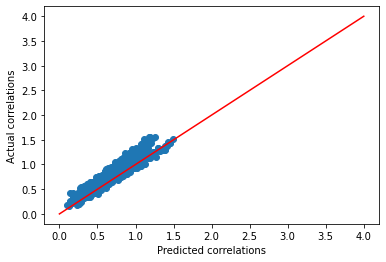

In [24]:
#W = model.model.get_loadings()
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

W = model.model.decoder.weight.detach().cpu().numpy()
eigvals = (W**2).sum(axis=0)
Weig = W / np.sqrt(eigvals)

d_estW = pdist(W)
dW = pdist(sims['W'])
# we appear to be off by a factor of 2 -- where is this coming from?
plt.scatter(dW, d_estW )
plt.plot(np.linspace(0, 4), np.linspace(0, 4), 'r')
plt.xlabel('Predicted correlations')
plt.ylabel('Actual correlations')

print(pearsonr(dW, d_estW))

In [12]:
np.diag(sims['W'].T @ sims['W'])

array([0.01  , 1.2325, 2.455 , 3.6775, 4.9   ])

In [13]:
np.diag(W.T @ W)

array([ 7.1032887,  7.289293 , 16.402346 , 16.745758 , 16.117823 ],
      dtype=float32)

In [14]:
eigvals

array([ 7.1032887,  7.289293 , 16.402346 , 16.745758 , 16.117823 ],
      dtype=float32)

In [15]:
eigvals = (W**2).sum(axis=0)
Weig = W / np.sqrt(eigvals)

In [16]:
Weig.T @ Weig

array([[ 0.99999994, -0.07350603,  0.266824  ,  0.12528475,  0.4624002 ],
       [-0.07350603,  1.0000001 ,  0.05637848,  0.19013375,  0.5294755 ],
       [ 0.266824  ,  0.05637848,  0.9999999 , -0.04203781,  0.39689505],
       [ 0.12528475,  0.19013375, -0.04203781,  1.        ,  0.05445005],
       [ 0.4624002 ,  0.5294755 ,  0.39689505,  0.05445005,  0.99999976]],
      dtype=float32)

In [17]:
Wu, Ws, Wv = np.linalg.svd(W)
k = W.shape[1]
Wu = Wu[:, :k]
Ws = Ws[:k]
Wv = Wv[:k, :]

In [18]:
np.linalg.norm(Weig.T @ Weig - np.eye(Weig.shape[-1]))

1.2554200541303684

In [19]:
Ws

array([5.063488 , 4.177951 , 3.3522055, 2.6704836, 1.4817407],
      dtype=float32)

In [20]:
eigvals = np.sqrt(np.sort(eigvals)[::-1])

In [21]:
np.sqrt(np.sum((eigvals - Ws)**2))

1.6733786

In [22]:
sims['sigma']

0.31622776601683794

In [23]:
torch.exp(model.model.log_sigma_sq)

tensor(0.0858, device='cuda:0', grad_fn=<ExpBackward>)